In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

def data_high_interaction(n_samples=400, random_state=42):
    np.random.seed(random_state)
    X = np.random.uniform(-2, 2, (n_samples, 3))
    f = X[:, 0] * X[:, 1] * np.sin(X[:, 2])
    noise_std = 0.3
    noise = np.random.normal(0, noise_std, n_samples)
    y = f + noise
    return X, y

X, y = data_high_interaction()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

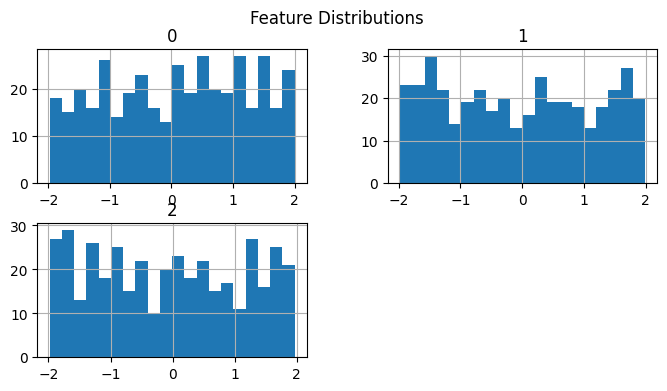

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(8, 4), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

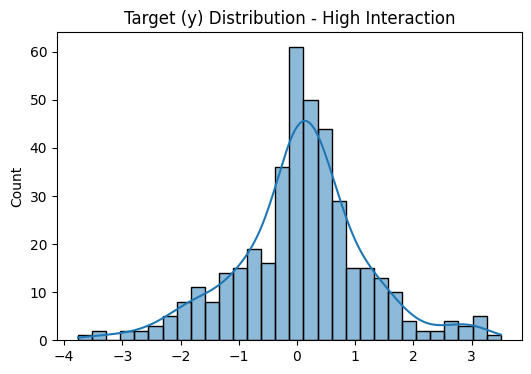

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True, bins=30)
plt.title("Target (y) Distribution - High Interaction")
plt.show()

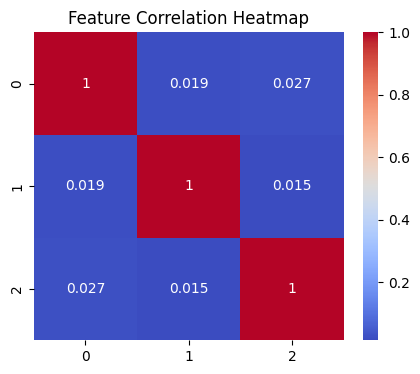

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Gelman-Rubin R

In [8]:
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=1000, nskip=100, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1100/1100 [00:28<00:00, 38.06it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.334


In [9]:
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=1000, nskip=100, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1100/1100 [00:04<00:00, 233.84it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.248


# Trace plot

In [10]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
bart_mtmh = MultiBART(ndpost=1000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10)
bart_mtmh.fit(X_train, y_train)
sigmas_mtmh = [trace.global_params['eps_sigma2'] for trace in bart_mtmh.sampler.trace]
means_mtmh = [trace.evaluate(X_train).mean() for trace in bart_mtmh.sampler.trace]
first_preds_mtmh = [trace.evaluate(X_train[0:1])[0] for trace in bart_mtmh.sampler.trace]

Iterations: 100%|██████████| 1000/1000 [00:27<00:00, 36.13it/s]


In [11]:
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
bart_default = DefaultBART(ndpost=1000, nskip=0, n_trees=100, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)
sigmas_default = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
means_default = [trace.evaluate(X_train).mean() for trace in bart_default.sampler.trace]
first_preds_default = [trace.evaluate(X_train[0:1])[0] for trace in bart_default.sampler.trace]

Iterations: 100%|██████████| 1000/1000 [00:04<00:00, 233.10it/s]


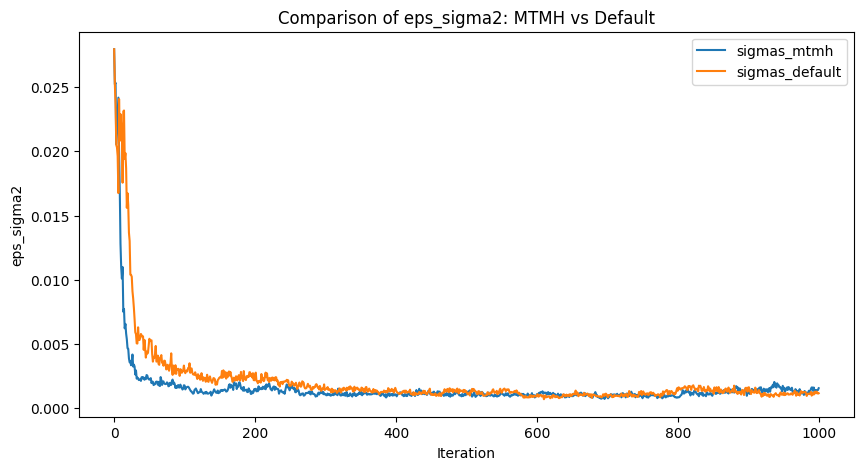

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sigmas_mtmh, label='sigmas_mtmh')
plt.plot(sigmas_default, label='sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of eps_sigma2: MTMH vs Default')
plt.show()

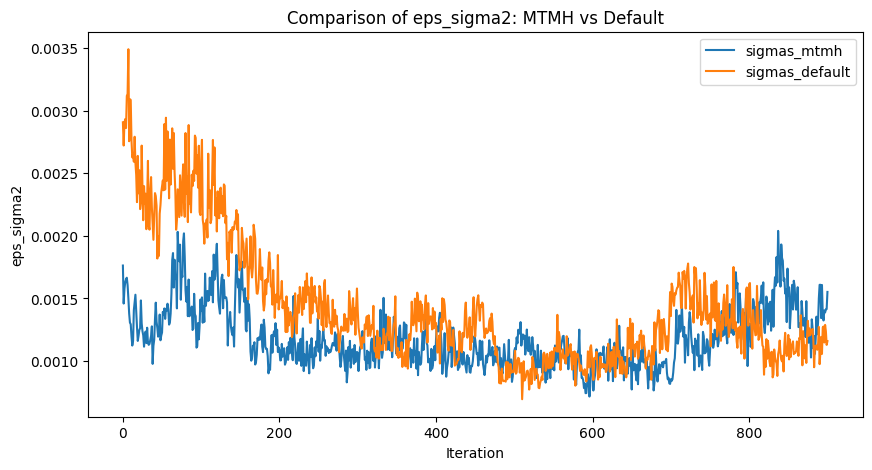

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(sigmas_mtmh[100:], label='sigmas_mtmh')
plt.plot(sigmas_default[100:], label='sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of eps_sigma2: MTMH vs Default')
plt.show()

# MSE

In [14]:
test_mse_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "sto", "rf", "xgb"]}
train_mse_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "sto", "rf", "xgb"]}
pi_length_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "sto", "rf", "xgb"]}

In [15]:
n_runs = 10
n_skip = 100
n_post = 100
n_trees = 100

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    
    # bart_mtmh
    t0 = time.time()
    proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
    bart_mtmh = MultiBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees, proposal_probs=proposal_probs, multi_tries=10, random_state=seed)
    bart_mtmh.fit(X_train, y_train)
    time_results["bart_mtmh"].append(time.time() - t0)
    
    # bart_default
    t0 = time.time()
    proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees, proposal_probs=proposal_probs, random_state=seed)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip, seed=seed)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_all_test = np.array(btpred_all_test)
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees}, 
               general_params = {"random_seed": seed},
               variance_forest_params={"num_trees": n_trees // 2}) 
    sto_pred_all_test, sto_all_sigma = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train)[0], axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    
    # Test MSE
    test_mse_results["bart_mtmh"].append(mean_squared_error(y_test, bart_mtmh.predict(X_test)))
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))


    # Train MSE
    train_mse_results["bart_mtmh"].append(mean_squared_error(y_train, bart_mtmh.predict(X_train)))
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))


    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    eps = np.zeros_like(btpred_all_test)
    for i in range(n_post):
        eps[i] = np.random.normal(0, btz.sigma[i], size=btpred_all_test.shape[1])
        btpred_all_test[i, :] += eps[i]    
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_eps = np.zeros_like(sto_pred_all_test)
    for i in range(n_post):
        sto_eps[:, i] = np.random.normal(np.zeros(sto_pred_all_test.shape[0]), sto_all_sigma[:, i])
        sto_pred_all_test[:, i] += sto_eps[:, i]
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart"].append(bart_covered)

    # bart_mtmh: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart_mtmh.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart_mtmh"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart_mtmh"].append(bart_covered)

Iterations: 100%|██████████| 200/200 [00:00<00:00, 247.89it/s]
INFO:2025-09-04 00:51:00,447:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-04 00:51:00,450:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/200 P_grow=0.60 P_prune=0.40 A_grow=0.35 A_prune=0.22 (burnin)
Iteration 200/200 P_grow=0.58 P_prune=0.42 A_grow=0.19 A_prune=0.26


Iterations: 100%|██████████| 200/200 [00:00<00:00, 246.39it/s]


Iteration 100/200 P_grow=0.55 P_prune=0.45 A_grow=0.33 A_prune=0.36 (burnin)
Iteration 200/200 P_grow=0.56 P_prune=0.44 A_grow=0.23 A_prune=0.32


Iterations: 100%|██████████| 200/200 [00:00<00:00, 242.37it/s]


Iteration 100/200 P_grow=0.56 P_prune=0.44 A_grow=0.29 A_prune=0.30 (burnin)
Iteration 200/200 P_grow=0.45 P_prune=0.55 A_grow=0.36 A_prune=0.24


Iterations: 100%|██████████| 200/200 [00:00<00:00, 238.62it/s]


Iteration 100/200 P_grow=0.56 P_prune=0.44 A_grow=0.34 A_prune=0.27 (burnin)
Iteration 200/200 P_grow=0.60 P_prune=0.40 A_grow=0.20 A_prune=0.15


Iterations: 100%|██████████| 200/200 [00:00<00:00, 244.82it/s]


Iteration 100/200 P_grow=0.53 P_prune=0.47 A_grow=0.26 A_prune=0.28 (burnin)
Iteration 200/200 P_grow=0.55 P_prune=0.45 A_grow=0.22 A_prune=0.24


Iterations: 100%|██████████| 200/200 [00:00<00:00, 238.88it/s]


Iteration 100/200 P_grow=0.56 P_prune=0.44 A_grow=0.23 A_prune=0.39 (burnin)
Iteration 200/200 P_grow=0.52 P_prune=0.48 A_grow=0.27 A_prune=0.33


Iterations: 100%|██████████| 200/200 [00:00<00:00, 244.92it/s]


Iteration 100/200 P_grow=0.45 P_prune=0.55 A_grow=0.29 A_prune=0.36 (burnin)
Iteration 200/200 P_grow=0.52 P_prune=0.48 A_grow=0.23 A_prune=0.29


Iterations: 100%|██████████| 200/200 [00:00<00:00, 244.26it/s]


Iteration 100/200 P_grow=0.52 P_prune=0.48 A_grow=0.25 A_prune=0.25 (burnin)
Iteration 200/200 P_grow=0.56 P_prune=0.44 A_grow=0.39 A_prune=0.23


Iterations: 100%|██████████| 200/200 [00:00<00:00, 239.89it/s]


Iteration 100/200 P_grow=0.55 P_prune=0.45 A_grow=0.29 A_prune=0.29 (burnin)
Iteration 200/200 P_grow=0.41 P_prune=0.59 A_grow=0.29 A_prune=0.27


Iterations: 100%|██████████| 200/200 [00:00<00:00, 243.63it/s]


Iteration 100/200 P_grow=0.62 P_prune=0.38 A_grow=0.23 A_prune=0.32 (burnin)
Iteration 200/200 P_grow=0.46 P_prune=0.54 A_grow=0.30 A_prune=0.41


In [16]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart_mtmh    0.305725
bart         0.322877
btz          0.369380
sto          1.340177
rf           0.950368
xgb          0.717581
dtype: float64
Train MSE Mean:
bart_mtmh    0.041074
bart         0.079228
btz          0.107939
sto          1.207854
rf           0.133793
xgb          0.000101
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart_mtmh    1.562004
bart         1.739445
btz          1.975290
sto          4.529812
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart_mtmh    0.856
bart         0.883
btz          0.901
sto          0.902
dtype: float64
Average Training Time (seconds) over 10 runs:
bart_mtmh    5.042277
bart         0.834244
btz          1.084936
sto          0.299016
rf           0.131184
xgb          0.052006
dtype: float64


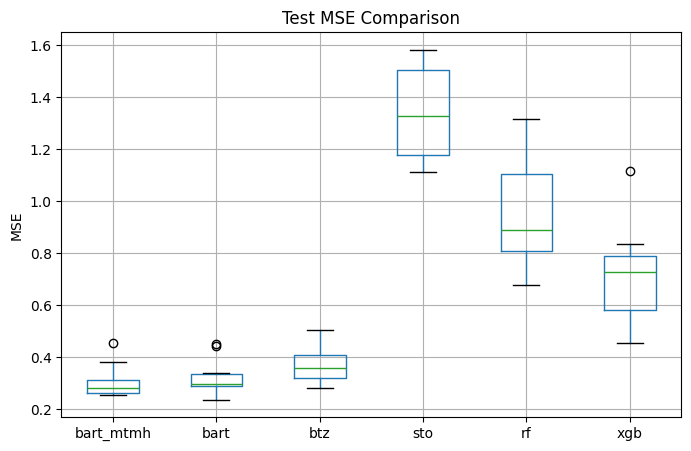

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

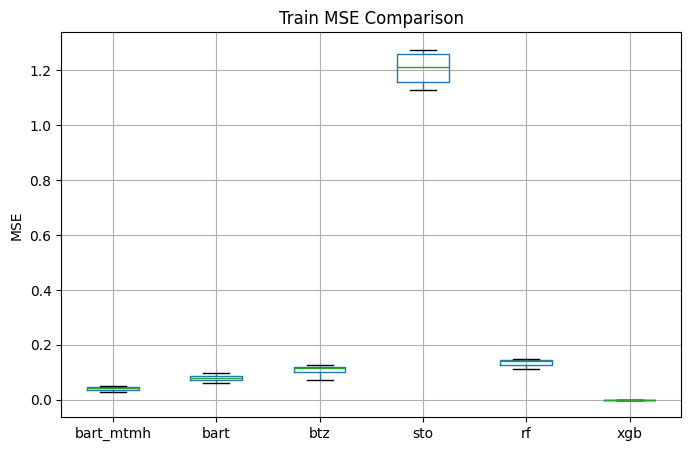

In [18]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

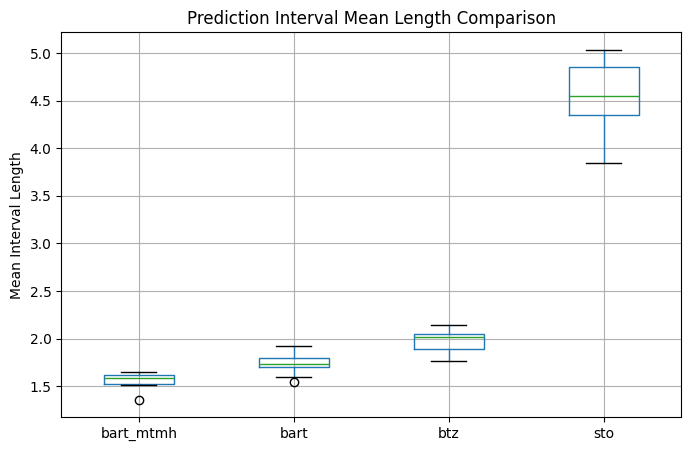

In [19]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

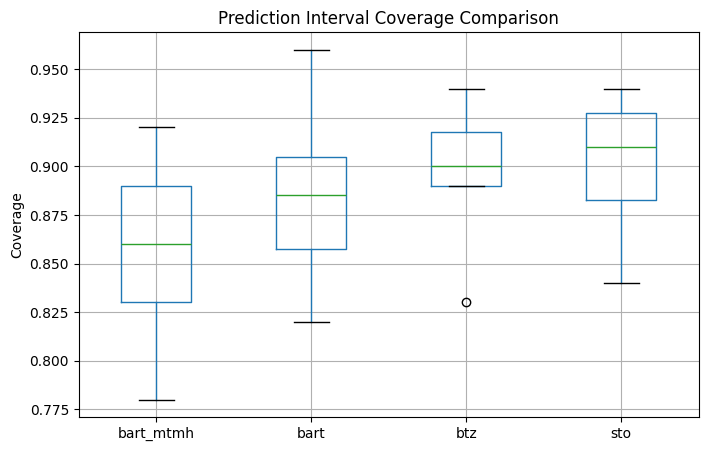

In [20]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

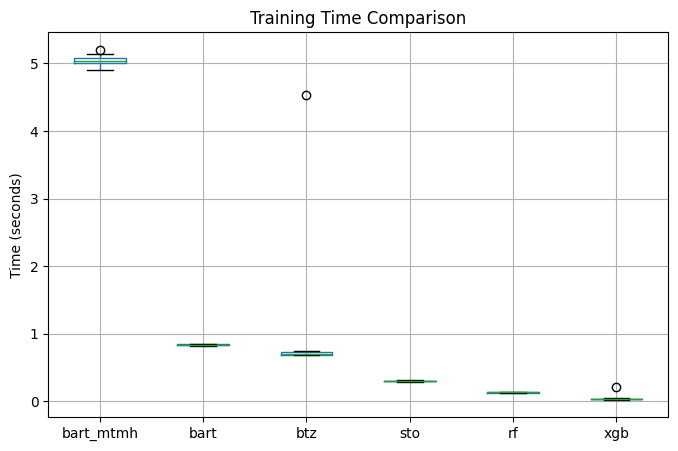

In [21]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()